# V.1 Exploring the green reds

## a) Function that plots a scatterplot matrix

In [1]:
from matplotlib import scale
%load_ext Cython


In [53]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [358]:
red_wine_data = pd.read_csv('resources/winequality-red.csv', sep=';')
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [359]:
red_wine_data = pd.read_csv('resources/winequality-red.csv', sep=';')
# Dictionary with column names which have space in the name as a key and replaced spaces to _ as value
columns_to_replace = {name: name.replace(' ', '_') for name in red_wine_data.columns if ' ' in name}

# Replace dataFrame colum names with spaces to names with '_' for better usability
red_wine_data.rename(columns=columns_to_replace, inplace=True)
red_wine_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# V.1 Exploring the green reds

## a) Function that plots a scatterplot matrix

In [343]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'quality']
    features = wine_data.columns
    features_amount = len(features) - 1
    
    data = wine_data[features]    
    good_wines = data[data['quality'] >= good_threshold]
    bad_wines = data[data['quality'] <= bad_threshold]    
    
    fig, axes = plt.subplots(nrows=features_amount, ncols=features_amount, figsize=(20,20))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for axis in axes.flat:
        # Hide all ticks and labels
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)

    for i in range(features_amount):
        for j in range(features_amount):
            if i == j:
                axes[i, j].annotate(good_wines.columns[i], (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
            else:
                axes[i, j].scatter(bad_wines.iloc[:, j], bad_wines.iloc[:, i], color='purple', marker='o', s=4)
                axes[i, j].scatter(good_wines.iloc[:, j], good_wines.iloc[:, i], color='green', marker='o', s=4) 
    plt.show()
    if save_plot:
        fig.savefig('figure.png')
    return good_wines, bad_wines

In [5]:
# df.apply(lambda data: 1 if data['quality'] >= 8 else 0, axis=1)
ddd = red_wine_data
ddd = ddd.apply(lambda x: x/x.max(), axis=0)
ddd.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0.492958,0.245455,0.216867,0.314590,0.130058,0.155709,0.386364,0.963445,0.785340,0.416667,0.619718,0.666667
1,0.443662,0.272727,0.204819,0.024316,0.141618,0.048443,0.300000,0.956708,0.863874,0.453704,0.669014,0.666667
2,0.570423,0.254545,0.240964,0.104863,0.144509,0.103806,0.220455,0.957766,0.853403,0.407407,0.711268,0.666667
3,0.507042,0.209091,0.192771,0.129179,0.167630,0.162630,0.422727,0.958248,0.835079,0.370370,0.697183,0.666667
4,0.507042,0.209091,0.192771,0.129179,0.167630,0.162630,0.422727,0.958248,0.835079,0.370370,0.697183,0.666667


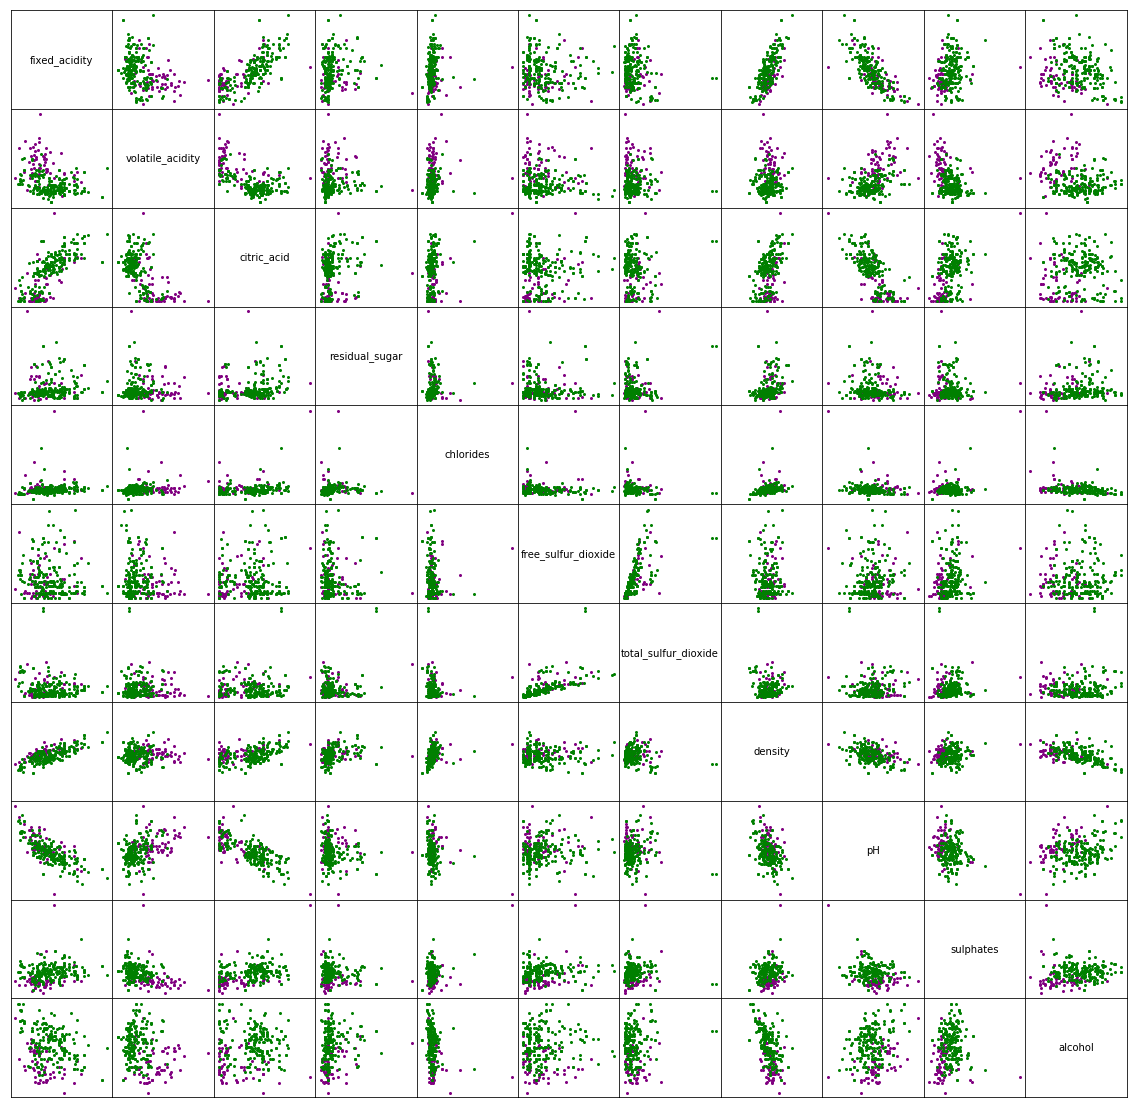

In [363]:
g, b = plot_scatter_matrix(red_wine_data, 7, 4)
# b.head(200)

## b)

/Users/mvorona/mvorona/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


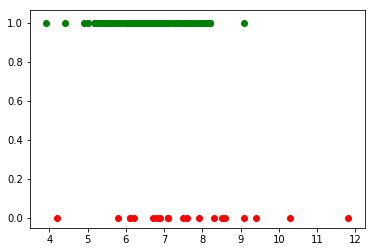

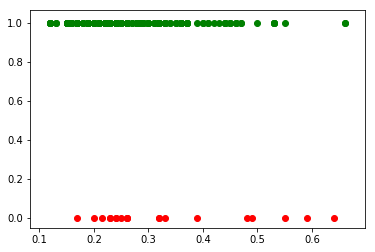

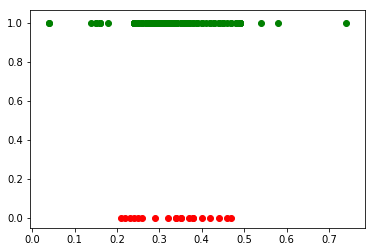

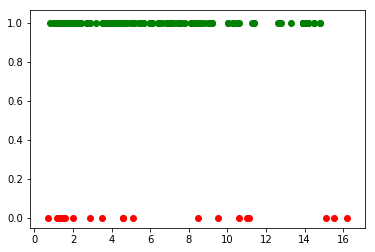

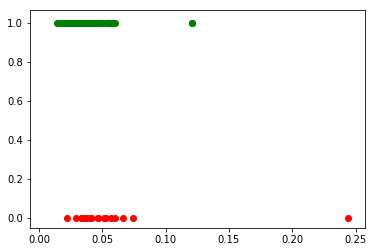

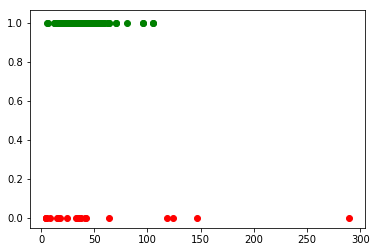

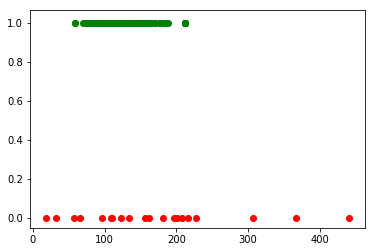

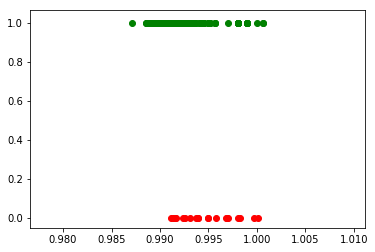

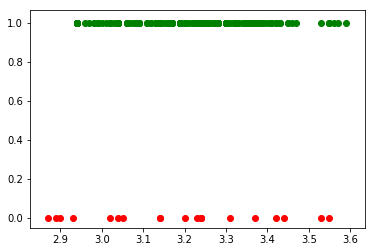

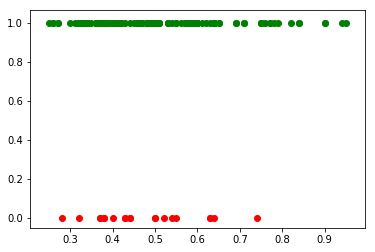

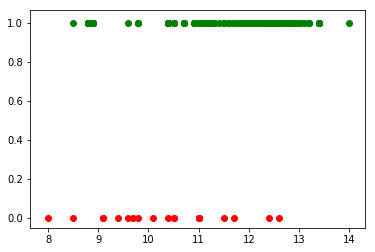

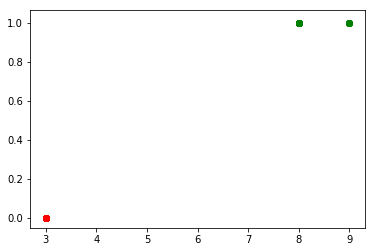

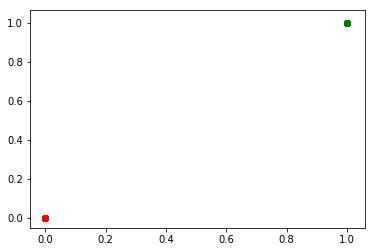

In [7]:
df = red_wine_data[(red_wine_data['quality'] >=8) | (red_wine_data['quality'] <= 3)]
df['y'] = df.apply(lambda data: 1 if data['quality'] >= 8 else 0, axis=1)
good = df[df['quality'] >= 8]
bad = df[df['quality'] <= 3]
# df.head(100)
# plt.scatter(df['fixed_acidity'], df['y'])
# plt.scatter(df['volatile_acidity'], df['y'])
# df.corr()
for col in df.columns:
    plt.scatter(good[col], good['y'], color='green')
    plt.scatter(bad[col], bad['y'], color='red')
    plt.show()
#     good.plot.scatter(x=col, y='y', color='DarkGreen', label='Group 2')
#     bad.plot.scatter(x=col, y='y', color='red', label='Group 2')

# Some correlation between clories and betwee fixed_acidity with y.

# V.2 Learning to perceptron

## a) Implement a perceptron that:
    • Has randomly initialized weights and bias
    • Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
    • Utilizes the heaviside step activation function (discrete version)

In [8]:
import random


# Make a prediction with weights
def predict(row, weights):
    activation = weights[0]
    for i in range(len(row) - 1):
        activation += weights[i + 1] * row[i]
    # Activation function is descrete 1 or 0
    return 1.0 if activation >= 0.0 else 0.0 
    # may be return 1.0 if activation >= 0.5 else 0.0 


# Estimate Perceptron weights using stochastic gradient descent
def train_weights(train, l_rate, n_epoch):
    # Random weights and bias initialization
    weights = [random.gauss(0.0, 0.01) for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        sum_error = 0.0
        correct_predictions = 0.0
        for row in train:
            prediction = predict(row, weights)
            if prediction == row[-1]:
                correct_predictions += 1
            error = row[-1] - prediction
            sum_error += error**2
            weights[0] = weights[0] + l_rate * error
            for i in range(len(row) - 1):
                weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
        if epoch % 10000 == 0:
            accuracy = correct_predictions / float(len(train))
            print('>epoch=%d, lrate=%.3f, error=%.3f accuracy=%.3f' % (epoch, l_rate, sum_error, accuracy))
    return weights

In [9]:
dataset = 
l_rate = 0.01
n_epoch = 20000
weights = train_weights(dataset.values, l_rate, n_epoch)
print('weights', weights)

SyntaxError: invalid syntax (<ipython-input-9-3bcf9c6ea265>, line 1)

#### b) You’ll need to implement a function to train your perceptron. Your training function should take in your red wine data as a parameter and should:
    • Have a way to specify number of training epochs
    • Train your perceptron until it makes no errors, if training epochs is set to 0,
    • Have a way to specify learning rate.
    • Return a list of python tuples containing (performance):
    
    [(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias),...]

In [10]:
activation = sum(weight_i * x_i) + bias

NameError: name 'weight_i' is not defined

In [11]:
prediction = 1.0 if activation >= 0.0 else 0.0

NameError: name 'activation' is not defined

#### For the Perceptron algorithm, each iteration the weights (w) are updated using the equation:
w = w + learning_rate * (expected - predicted) * x

In [12]:
w = w + learning_rate * (expected - predicted) * x

NameError: name 'w' is not defined

##### There is one weight for each input attribute, and these are updated in a consistent way, for example:
w(t+1)= w(t) + learning_rate * (expected(t) - predicted(t)) * x(t)

##### The bias is updated in a similar way, except without an input as it is not associated with a specific input value:
bias(t+1) = bias(t) + learning_rate * (expected(t) - predicted(t))


In [165]:
df = red_wine_data[(red_wine_data['quality'] >=8) | (red_wine_data['quality'] <= 3)]
df['y'] = df.apply(lambda data: 1.0 if data['quality'] >= 8 else 0.0, axis=1)

# dataset = df.drop('quality', 1).drop('alcohol', 1).drop('density', 1)
dataset = df[['alcohol', 'pH', 'y']]
dataset.head(20)

/Users/mvorona/mvorona/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,alcohol,pH,y
17,12.8,3.33,1.0
20,12.8,3.33,1.0
22,10.5,3.47,1.0
68,10.7,3.33,1.0
74,10.7,3.33,1.0
158,12.1,3.36,1.0
159,12.1,3.36,1.0
188,12.7,3.26,1.0
251,9.8,3.02,0.0
253,11.7,3.53,0.0


##### Below is a function named predict() that predicts an output value for a row given a set of weights.

The first weight is always the bias as it is standalone and not responsible for a specific input value.

In [349]:
import random


class Perseptron:
    def __init__(self, learning_rate: float, n_epoch: int, dataset):
        self.weights = [random.gauss(2.0, 0.5) for i in range(len(dataset[0]))]
        self.learning_rate = learning_rate
        self.dataset = dataset
        self.n_epoch = n_epoch
        self.sum_error = 0.0
        self.correct_predictions = 0
        self.wrong_predictions = 0
        self.accuracy = 0.0
        self.current_epoch = 0
        self.training_statistics = list()
        self.error = 0.0
        
    def __predict(self, row):
        activation = self.weights[0]
        for i in range(len(row) - 1):
            activation += (self.weights[i + 1] * row[i])
#         self.error = activation
#         print(self.error)
        return 1.0 if activation > 0.05 else 0.0
    
    def __calculate_weights(self):
        for row in self.dataset:
            prediction = self.__predict(row)
            if prediction == row[-1]:
                self.correct_predictions += 1
            error = row[-1] - prediction
            self.sum_error += error**2
#             self.sum_error += self.error**2
            self.weights[0] += (self.learning_rate * error)
#             self.weights[0] += self.learning_rate * self.error
            for i in range(len(row) - 1):
                self.weights[i + 1] += (self.learning_rate * error * row[i])
        self.accuracy = self.correct_predictions / len(self.dataset)
        self.wrong_predictions = len(self.dataset) - self.correct_predictions
    
    @property
    def stop_training(self):
        return (self.n_epoch != 0 and self.current_epoch == self.n_epoch) or (self.n_epoch == 0 and self.sum_error == 0.0)
    
    def __clean_statistics(self):
        self.accuracy = 0.0
        self.wrong_predictions = 0.0
        self.correct_predictions = 0.0
        self.sum_error = 0.0
    
    def train_perceptron(self):
#         self.weights = [random.gauss(10.0, 20) for i in range(len(self.dataset[0]))]
#         self.current_epoch = 0
        while True:
            if self.stop_training:
                break
            self.__calculate_weights()
#             message = f'current_epoch: {self.current_epoch}, n_errors: {self.wrong_predictions}, accuracy: {self.accuracy}'
#             print(message)
            training_data = (self.current_epoch, self.wrong_predictions, self.weights[1:], self.weights[0], self.accuracy)
            self.training_statistics.append(training_data)
            self.__clean_statistics()
            self.current_epoch += 1
        return self.training_statistics
    

# p = Perseptron(0.07, 200000, dataset.values)
# result_data = p.train_perceptron()

/Users/mvorona/mvorona/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


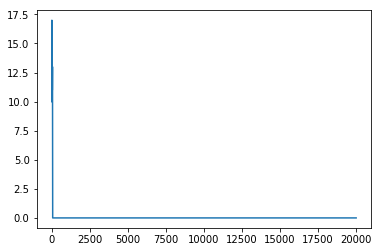

In [365]:
# result_data = p.train_perceptron()
dataset = red_wine_data[(red_wine_data['quality'] >=8) | (red_wine_data['quality'] <= 3)]
dataset['y'] = dataset.apply(lambda data: 1.0 if data['quality'] >= 8 else 0.0, axis=1)
dataset = dataset[['alcohol', 'pH', 'y']]

p = Perseptron(0.01, 20000, dataset.values)
result_data = p.train_perceptron()
errors = [elem[1] for elem in result_data]
epochs = [elem[0] for elem in result_data]
plt.plot(epochs, errors)
plt.show()
# weights = [[round(el, 3) for el in elem[2]] for elem in result_data]
# weights

1.0061648118347366

In [33]:
import random


# Make a prediction with weights
def predict(row, weights):
    activation = weights[0]
    for i in range(len(row) - 1):
        activation += weights[i + 1] * row[i]
    # Activation function is descrete 1 or 0
#     return 1.0 if activation >= 0.0 else 0.0 
    return 1.0 if activation >= 0.5 else 0.0 
    # may be return 1.0 if activation >= 0.5 else 0.0 


def calculate_weights()    
    

# Estimate Perceptron weights using stochastic gradient descent
def train_perceptron(train, l_rate, n_epoch):
    # Random weights and bias initialization
    weights = [random.gauss(0.0, 0.01) for i in range(len(train[0]))]
    
    for epoch in range(n_epoch):
        sum_error = 0.0
        correct_predictions = 0.0
        for row in train:
            prediction = predict(row, weights)
            if prediction == row[-1]:
                correct_predictions += 1
            error = row[-1] - prediction
            sum_error += error**2
            weights[0] = weights[0] + l_rate * error
            for i in range(len(row) - 1):
                weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
        if epoch % 10000 == 0:
            accuracy = correct_predictions / float(len(train))
            print('>epoch=%d, lrate=%.3f, error=%.3f accuracy=%.3f' % (epoch, l_rate, sum_error, accuracy))
    return weights

# df2 = red_wine_data
# df2['y'] = red_wine_data.apply(lambda data: 1 if data['quality'] >= 7 else 0, axis=1)
# dataset = df2.drop('quality', 1).drop('alcohol', 1)
# dataset = df.drop('quality', 1).drop('alcohol', 1)

l_rate = 0.001
n_epoch = 200000
weights = train_perceptron(dataset.values, l_rate, n_epoch)
print(weights)


True
>epoch=0, lrate=0.001, error=35.000 accuracy=0.825
>epoch=0, lrate=0.001, error=35.000 accuracy=0.825
[0.00825418067432104, 0.04722736933836729, 0.01866229497526891]


In [35]:
type(dataset.values)

numpy.ndarray

In [489]:
%%cython
from cpython cimport array
import array

# def array.array a = array.array(l1)
cdef array.array a = array.array('i', [1, 2, 3])
print(a)
a

In [528]:
dataset.head()
# dataset.values[0, 0]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,y
17,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,1
20,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,1
22,6.8,0.26,0.42,1.7,0.049,41.0,122.0,0.9930,3.47,0.48,10.5,1
68,6.7,0.23,0.31,2.1,0.046,30.0,96.0,0.9926,3.33,0.64,10.7,1
74,6.7,0.23,0.31,2.1,0.046,30.0,96.0,0.9926,3.33,0.64,10.7,1


(<Figure size 432x288 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8481e2bbe0>,
       dtype=object))

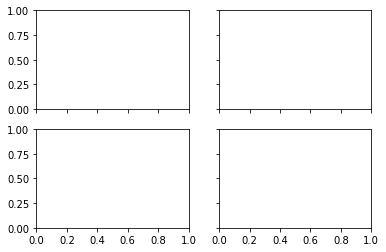

In [12]:
plt.subplots(2, 2, sharex='all', sharey='all')
